# Selecció de Models
En la Demo1 només este en compte la filtració de dades (Tractaments de valors faltants) i eliminació de columnes que no tenen correlació amb el **target = winner**.

- **Model 1:** Elimació de les columnes de la correlació
- **Model 2:** + Elimació de les columnes que determinen quin heroi a acabat amb una estructura
- **Model 3:** + Eliminació dels *first*

**NOTA:** Algunes de les funcions utilitzades estan en el document **funcions.py** per millorar al visualització del NoteBook

In [1]:
# Primer de tot carreguem les llibreries necessàries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn as sk


from Combinacions_encanteris import *
from demo3_funcions import *
from funcions import *

In [2]:
# Regressió logística
from sklearn.linear_model import LogisticRegression
# Random Forest
from sklearn.ensemble import RandomForestClassifier
# Gradient Boosting 
from sklearn.ensemble import GradientBoostingClassifier
# SVM
from sklearn.svm import SVC

In [3]:
DataSet = pd.read_csv('../../LOL - Dataset/games.csv')

print("📊 RESUM DE LES DADES ORIGINALS:")
print(f"Files: {DataSet.shape[0]}, Columnes: {DataSet.shape[1]}")
print(f"\nValors NaN totals: {DataSet.isna().sum().sum()}")
print(f"Files amb NaN: {DataSet.isna().any(axis=1).sum()}")

# Eliminar duplicats
duplicated_rows = DataSet[DataSet.duplicated(keep=False)]
print(f"\n📋 Nombre de files duplicades: {len(duplicated_rows)} de {len(DataSet)}")
DataSet_cleaned = DataSet.drop_duplicates()
print(f"✅ Files després d'eliminar duplicats: {len(DataSet_cleaned)}")

📊 RESUM DE LES DADES ORIGINALS:
Files: 51490, Columnes: 61

Valors NaN totals: 0
Files amb NaN: 0

📋 Nombre de files duplicades: 861 de 51490
✅ Files després d'eliminar duplicats: 51053


Com hem determinat al final del document de **Correlació**, eliminarem els atributs que no tenen correlació directa amb el target **winner** i afegirem les columnes comentades en **Combinacions_Encanteris.ipynb**

In [4]:
# Retorna un diccionari per poder descodificar les combinacions d'equips
combinacions_equip = comptar_combinacions_equip(DataSet_cleaned)
combinacions_equip_list = list(combinacions_equip.keys())
combinacions_equips_df = pd.DataFrame(combinacions_equip_list, columns=['champ1_id', 'champ2_id', 'champ3_id', 'champ4_id', 'champ5_id'])

# Afegir índexs d'equips (ja tenim la funció)
DataSet_reduit = afegir_combinacions_equips_a_dataset(DataSet_cleaned, combinacions_equips_df)


c:\Users\laiao\OneDrive\Desktop\UNI\3. Aprenentatge Computacional\Kaggle-Code\Selecció de Model\Demo3\demo3_funcions.py:639: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team1_comb_index'] = keys1.map(_key_to_index).astype('Int64')
c:\Users\laiao\OneDrive\Desktop\UNI\3. Aprenentatge Computacional\Kaggle-Code\Selecció de Model\Demo3\demo3_funcions.py:640: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['team2_comb_index'] = keys2.map(_key_to_index).astype('Int64')


In [5]:
DataSet_amb_sinergia, sinergia_df = implementar_sinergia_model(DataSet_reduit, combinacions_equips_df)
DataSet_amb_tag = implementar_tags_model(DataSet_amb_sinergia, DataSet_reduit, combinacions_equips_df, min_partides=5)
DataSet_cleaned = afegir_score_sinergia_encanteris(DataSet_amb_tag, min_synergy_games=50)

🚀 Carregant JSON per PRIMERA vegada...
ANÀLISI DE SINERGIA ENTRE HEROIS

Parelles analitzades: 9407

TOP 10 PARELLES AMB MILLOR SINERGIA:
--------------------------------------------------
Nidalee         + Shyvana         | WR: 92.86% | Sinergia: 0.846 | Aparicions: 14
Graves          + Hecarim         | WR: 85.00% | Sinergia: 0.759 | Aparicions: 10
Nocturne        + Aurelion Sol    | WR: 84.21% | Sinergia: 0.732 | Aparicions: 19
Kassadin        + Udyr            | WR: 84.21% | Sinergia: 0.732 | Aparicions: 19
Mordekaiser     + Camille         | WR: 93.75% | Sinergia: 0.714 | Aparicions: 8
Karthus         + Xerath          | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Warwick         + Rek'Sai         | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Rumble          + Skarner         | WR: 88.89% | Sinergia: 0.713 | Aparicions: 9
Malphite        + Nocturne        | WR: 82.14% | Sinergia: 0.706 | Aparicions: 28
Anivia          + Aatrox          | WR: 81.82% | Sinergia: 0.702 | Aparicions

In [6]:
cols_to_remove = [f't{team}_champ{i}id' for team in [1, 2] for i in range(1, 6)]
cols_to_remove += [f't{team}_champ{champ}_sum{s}' for team in [1, 2] for champ in range(1, 6) for s in [1,2]]
cols_to_remove += [f't{team}_ban{champ}' for team in [1, 2] for champ in range(1, 6)]
cols_to_remove += ['creationTime', 'gameDuration', 'seasonId']

# Verificar quines columnes existeixen
existing_cols = [col for col in cols_to_remove if col in DataSet_cleaned.columns]
DataSet_cleaned = DataSet_cleaned.drop(columns=existing_cols, errors='ignore')
print(f"Columnes restants: {DataSet_cleaned.shape[1]}")

DataSet_cleaned = DataSet_cleaned.dropna()

Columnes restants: 28


## Preparació de les dades d'entrenament i predicció
A continuació farem la validació creuada i la selecció dels hiperparàmetres

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

def split_data(X, y, test_size=0.2, val_size=0.2, random_state=42):
    """
    Separa les dades en train, validation i test
    """
    # Primer separació: train+val (80%) i test (20%)
    X_train_val, X_test, y_train_val, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Segona separació: train (60%) i val (20%)
    val_relative_size = val_size / (1 - test_size)
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_val, y_train_val, test_size=val_relative_size, 
        random_state=random_state, stratify=y_train_val
    )
    
    print(f"Train shape: {X_train.shape}")
    print(f"Validation shape: {X_val.shape}")
    print(f"Test shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def scale_data(X_train, X_val, X_test, method='standard'):
    """
    Normalitza/estandarditza les dades
    """
    if method == 'standard':
        scaler = StandardScaler()
    elif method == 'minmax':
        scaler = MinMaxScaler()
    else:
        raise ValueError("Mètode ha de ser 'standard' o 'minmax'")
    
    # Entrenar el scaler només amb les dades d'entrenament
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    return X_train_scaled, X_val_scaled, X_test_scaled, scaler


In [8]:
X = DataSet_cleaned.drop('winner', axis=1)
y = DataSet_cleaned['winner']

print(f"\n🎯 DATES PER A MODELACIÓ:")
print(f"X shape: {X.shape}")
print(f"y shape: {y.shape}")
print(f"\nDistribució de la variable objectiu:")
print(y.value_counts(normalize=True))
y = y.map({1: 0, 2: 1})


🎯 DATES PER A MODELACIÓ:
X shape: (50626, 27)
y shape: (50626,)

Distribució de la variable objectiu:
winner
1    0.506637
2    0.493363
Name: proportion, dtype: float64


In [9]:
# Separar dades
print(f"\n{'='*60}")
print("SEPARANT LES DADES (Train/Val/Test)")
print(f"{'='*60}")
X_train, X_val, X_test, y_train, y_val, y_test = split_data(
    X, y, test_size=0.2, val_size=0.2
)

# Escalar dades
print(f"\n{'='*60}")
print("NORMALITZANT LES DADES")
print(f"{'='*60}")
X_train_scaled, X_val_scaled, X_test_scaled, scaler = scale_data(
    X_train, X_val, X_test, method='standard'
)


SEPARANT LES DADES (Train/Val/Test)
Train shape: (30375, 27)
Validation shape: (10125, 27)
Test shape: (10126, 27)

NORMALITZANT LES DADES



MODEL 1: REGRESSIÓ LOGÍSTICA

VALIDACIÓ CREUADA EXHAUSTIVA (CV=5)

📊 RESULTATS PER CADA MÈTRICA:

  ACCURACY     (Test):
    • Scores per fold: ['0.9663', '0.9653', '0.9631', '0.9667', '0.9671']
    • Mitjana: 0.9657 ± 0.0014
    • IC 95%: [0.9629, 0.9685]
    • Train vs Test gap: 0.0005 (OK)

  F1           (Test):
    • Scores per fold: ['0.9659', '0.9648', '0.9627', '0.9663', '0.9667']
    • Mitjana: 0.9653 ± 0.0014
    • IC 95%: [0.9625, 0.9681]
    • Train vs Test gap: 0.0005 (OK)

  PRECISION    (Test):
    • Scores per fold: ['0.9641', '0.9640', '0.9602', '0.9672', '0.9639']
    • Mitjana: 0.9639 ± 0.0022
    • IC 95%: [0.9595, 0.9683]
    • Train vs Test gap: 0.0005 (OK)

  RECALL       (Test):
    • Scores per fold: ['0.9676', '0.9656', '0.9653', '0.9653', '0.9696']
    • Mitjana: 0.9667 ± 0.0017
    • IC 95%: [0.9634, 0.9701]
    • Train vs Test gap: 0.0005 (OK)

  ROC_AUC      (Test):
    • Scores per fold: ['0.9960', '0.9954', '0.9950', '0.9959', '0.9961']
    • Mitjana: 0

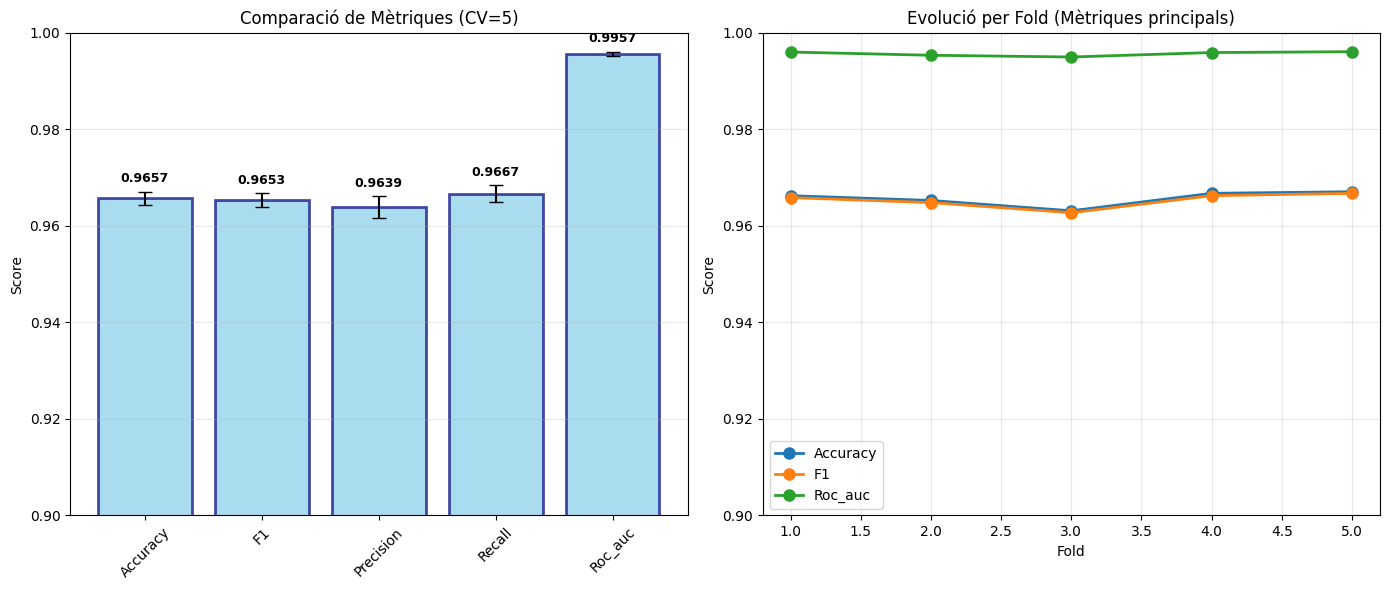

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'solver': 'liblinear', 'penalty': 'l2', 'max_iter': 1000, 'C': 0.1}
Millor score (CV) [accuracy]: 0.9661

AVALUACIÓ DEL MODEL: Regressió Logística (Val)
Valors únics a y_test: [0 1]


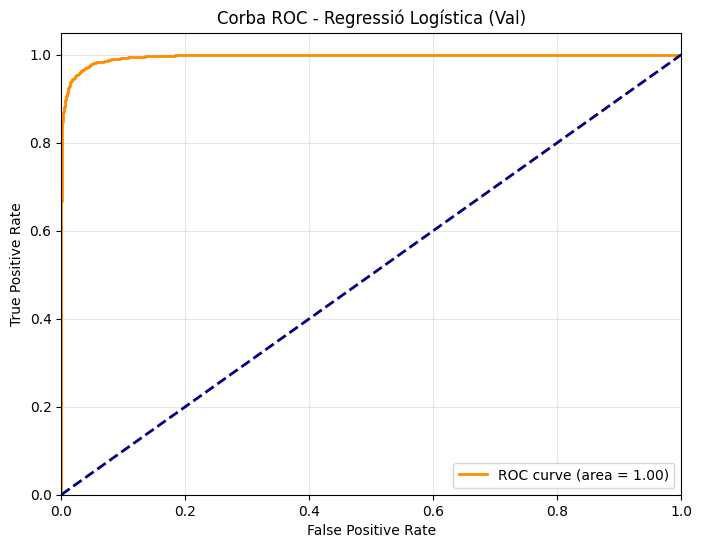


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9651
Precision: 0.9648
Recall: 0.9646
F1-Score: 0.9647
ROC-AUC: 0.9958

📊 Matriu de Confusió:
[[4954  176]
 [ 177 4818]]


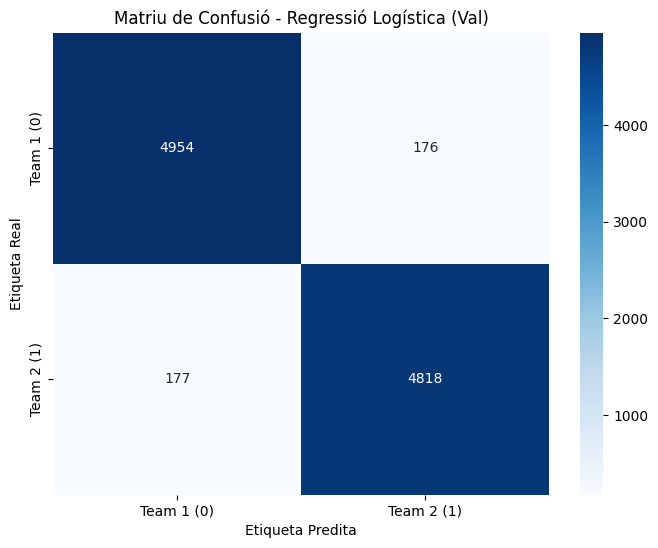


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5130
  Team 2 (1)       0.96      0.96      0.96      4995

    accuracy                           0.97     10125
   macro avg       0.97      0.97      0.97     10125
weighted avg       0.97      0.97      0.97     10125



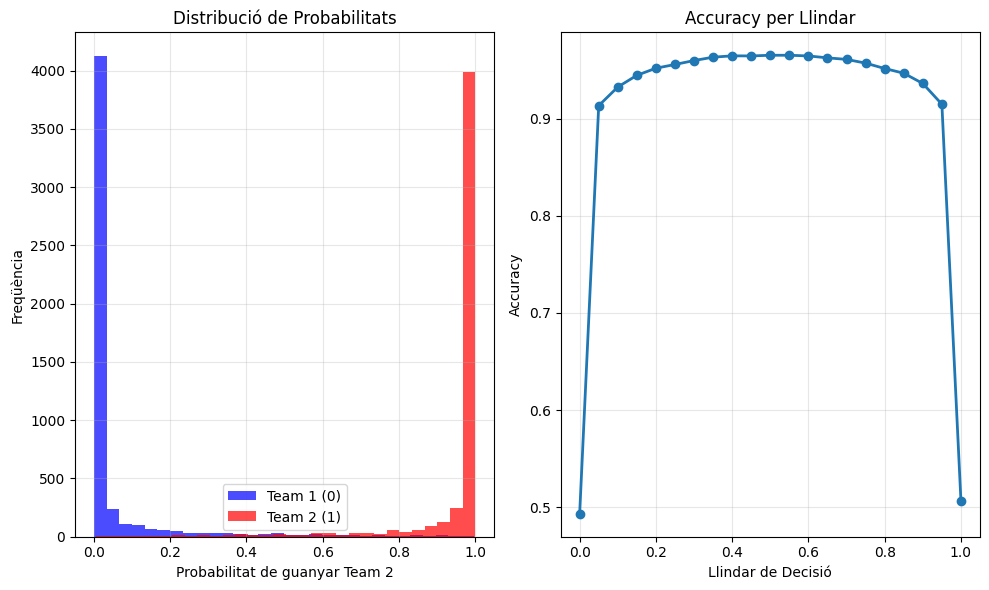

In [10]:
# Model 1: Regressió Logística
print(f"\n{'='*60}")
print("MODEL 1: REGRESSIÓ LOGÍSTICA")
print(f"{'='*60}")

from sklearn.linear_model import LogisticRegression

# Validació creuada
lr_base = LogisticRegression(max_iter=2000, random_state=42)
cv_scores_lr = cross_validation_analysis(lr_base, X_train_scaled, y_train, cv=5)

# Ajust d'hiperparàmetres
param_grids = get_param_grids()
lr_best, lr_params, lr_search = hyperparameter_tuning(
    lr_base, 
    param_grids['logistic'], 
    X_train_scaled, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
lr_metrics, lr_cm = evaluate_model(lr_best, X_val_scaled, y_val, "Regressió Logística (Val)")

# Guardar resultats
results = {}
results['Logistic Regression'] = {
    'model': lr_best,
    'params': lr_params,
    'cv_score': cv_scores_lr.mean(),
    'val_metrics': lr_metrics
}



MODEL 2: RANDOM FOREST

VALIDACIÓ CREUADA EXHAUSTIVA (CV=5)

📊 RESULTATS PER CADA MÈTRICA:

  ACCURACY     (Test):
    • Scores per fold: ['0.9720', '0.9723', '0.9709', '0.9760', '0.9774']
    • Mitjana: 0.9737 ± 0.0025
    • IC 95%: [0.9688, 0.9787]
    • Train vs Test gap: 0.0263 (OK)

  F1           (Test):
    • Scores per fold: ['0.9716', '0.9719', '0.9705', '0.9756', '0.9772']
    • Mitjana: 0.9734 ± 0.0026
    • IC 95%: [0.9683, 0.9784]
    • Train vs Test gap: 0.0266 (OK)

  PRECISION    (Test):
    • Scores per fold: ['0.9735', '0.9742', '0.9684', '0.9782', '0.9757']
    • Mitjana: 0.9740 ± 0.0032
    • IC 95%: [0.9677, 0.9803]
    • Train vs Test gap: 0.0260 (OK)

  RECALL       (Test):
    • Scores per fold: ['0.9696', '0.9696', '0.9726', '0.9730', '0.9787']
    • Mitjana: 0.9727 ± 0.0033
    • IC 95%: [0.9662, 0.9792]
    • Train vs Test gap: 0.0273 (OK)

  ROC_AUC      (Test):
    • Scores per fold: ['0.9977', '0.9968', '0.9971', '0.9978', '0.9980']
    • Mitjana: 0.9975 

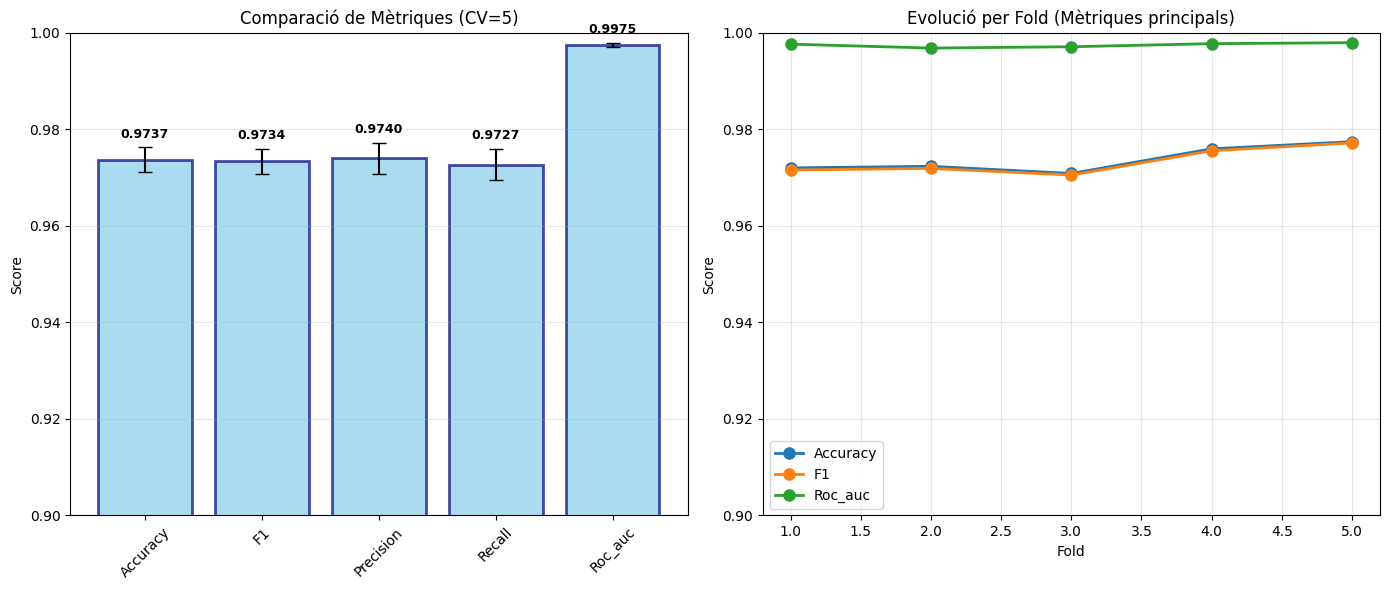

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
Millor score (CV) [accuracy]: 0.9742

AVALUACIÓ DEL MODEL: Random Forest (Val)
Valors únics a y_test: [0 1]


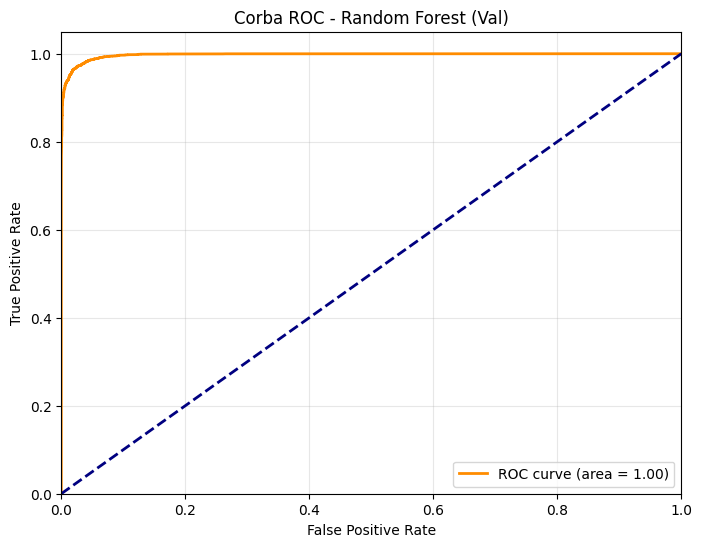


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9727
Precision: 0.9729
Recall: 0.9718
F1-Score: 0.9724
ROC-AUC: 0.9973

📊 Matriu de Confusió:
[[4995  135]
 [ 141 4854]]


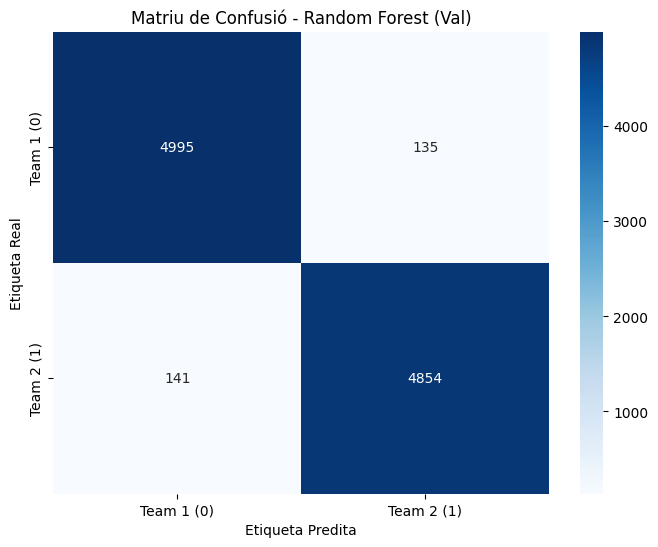


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5130
  Team 2 (1)       0.97      0.97      0.97      4995

    accuracy                           0.97     10125
   macro avg       0.97      0.97      0.97     10125
weighted avg       0.97      0.97      0.97     10125



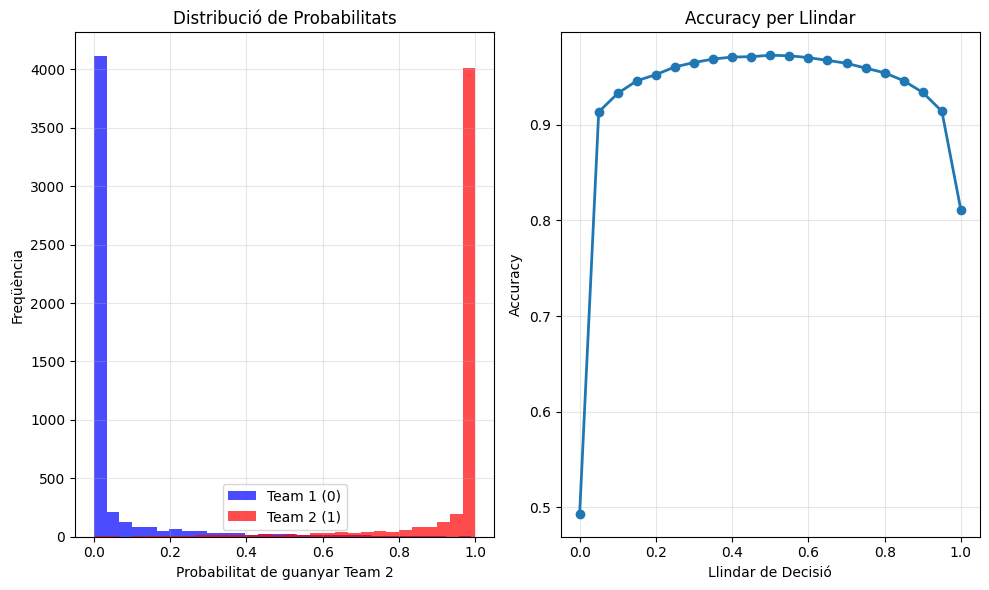

In [11]:
# Cèl·lula 8: Model 2 - Random Forest
print(f"\n{'='*60}")
print("MODEL 2: RANDOM FOREST")
print(f"{'='*60}")

from sklearn.ensemble import RandomForestClassifier

# Validació creuada
rf_base = RandomForestClassifier(random_state=42)
cv_scores_rf = cross_validation_analysis(rf_base, X_train, y_train, cv=5)

# Ajust d'hiperparàmetres
rf_best, rf_params, rf_search = hyperparameter_tuning(
    rf_base, 
    param_grids['random_forest'], 
    X_train, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
rf_metrics, rf_cm = evaluate_model(rf_best, X_val, y_val, "Random Forest (Val)")

# Guardar resultats
results['Random Forest'] = {
    'model': rf_best,
    'params': rf_params,
    'cv_score': cv_scores_rf.mean(),
    'val_metrics': rf_metrics
}


MODEL 3: GRADIENT BOOSTING

VALIDACIÓ CREUADA EXHAUSTIVA (CV=5)

📊 RESULTATS PER CADA MÈTRICA:

  ACCURACY     (Test):
    • Scores per fold: ['0.9719', '0.9717', '0.9723', '0.9747', '0.9753']
    • Mitjana: 0.9732 ± 0.0015
    • IC 95%: [0.9702, 0.9761]
    • Train vs Test gap: 0.0038 (OK)

  F1           (Test):
    • Scores per fold: ['0.9715', '0.9712', '0.9719', '0.9743', '0.9750']
    • Mitjana: 0.9728 ± 0.0016
    • IC 95%: [0.9697, 0.9758]
    • Train vs Test gap: 0.0039 (OK)

  PRECISION    (Test):
    • Scores per fold: ['0.9716', '0.9732', '0.9732', '0.9746', '0.9737']
    • Mitjana: 0.9733 ± 0.0010
    • IC 95%: [0.9714, 0.9752]
    • Train vs Test gap: 0.0040 (OK)

  RECALL       (Test):
    • Scores per fold: ['0.9713', '0.9693', '0.9706', '0.9740', '0.9763']
    • Mitjana: 0.9723 ± 0.0025
    • IC 95%: [0.9674, 0.9772]
    • Train vs Test gap: 0.0037 (OK)

  ROC_AUC      (Test):
    • Scores per fold: ['0.9978', '0.9974', '0.9972', '0.9979', '0.9981']
    • Mitjana: 0.9

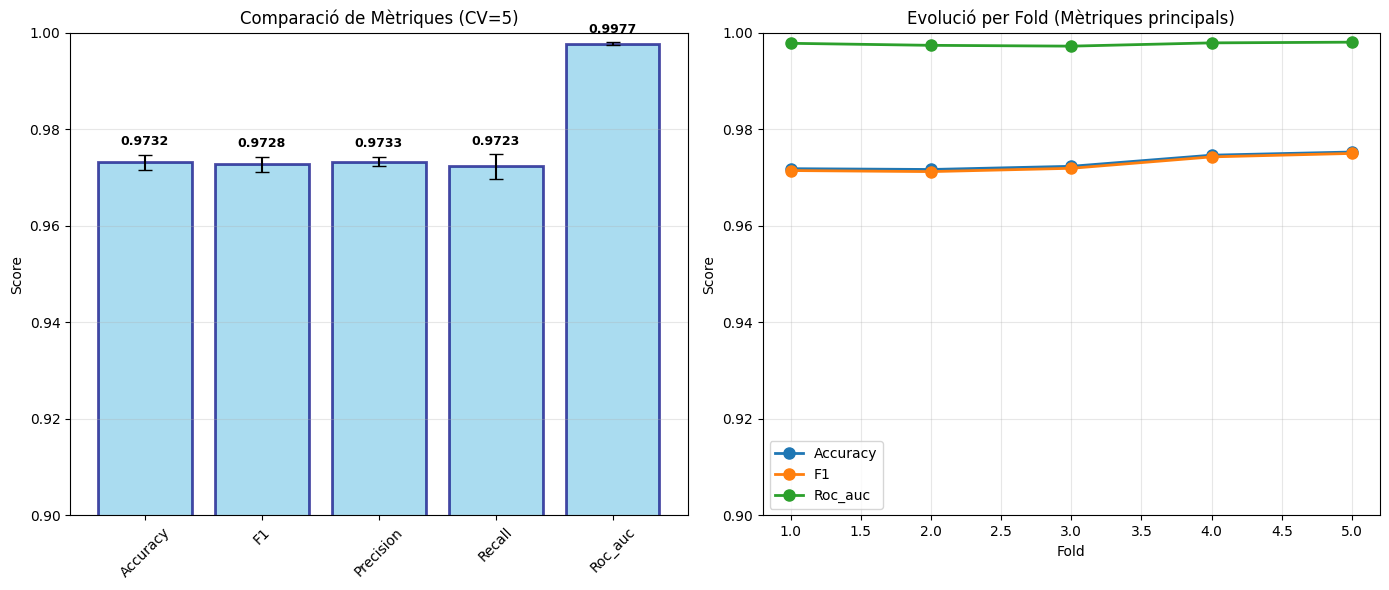

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Millors paràmetres: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': 4, 'learning_rate': 0.1}
Millor score (CV) [accuracy]: 0.9741

AVALUACIÓ DEL MODEL: Gradient Boosting (Val)
Valors únics a y_test: [0 1]


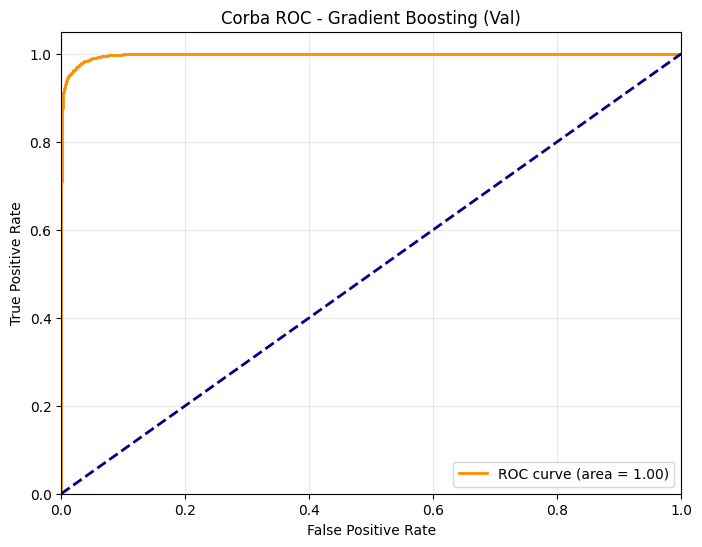


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9719
Precision: 0.9725
Recall: 0.9704
F1-Score: 0.9714
ROC-AUC: 0.9975

📊 Matriu de Confusió:
[[4993  137]
 [ 148 4847]]


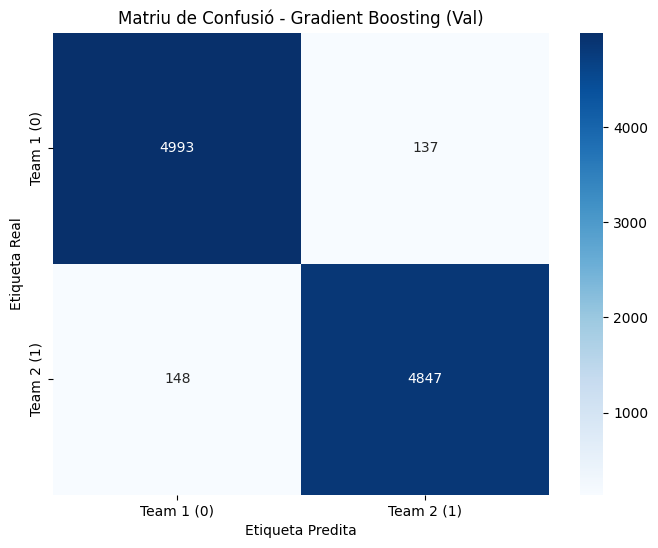


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5130
  Team 2 (1)       0.97      0.97      0.97      4995

    accuracy                           0.97     10125
   macro avg       0.97      0.97      0.97     10125
weighted avg       0.97      0.97      0.97     10125



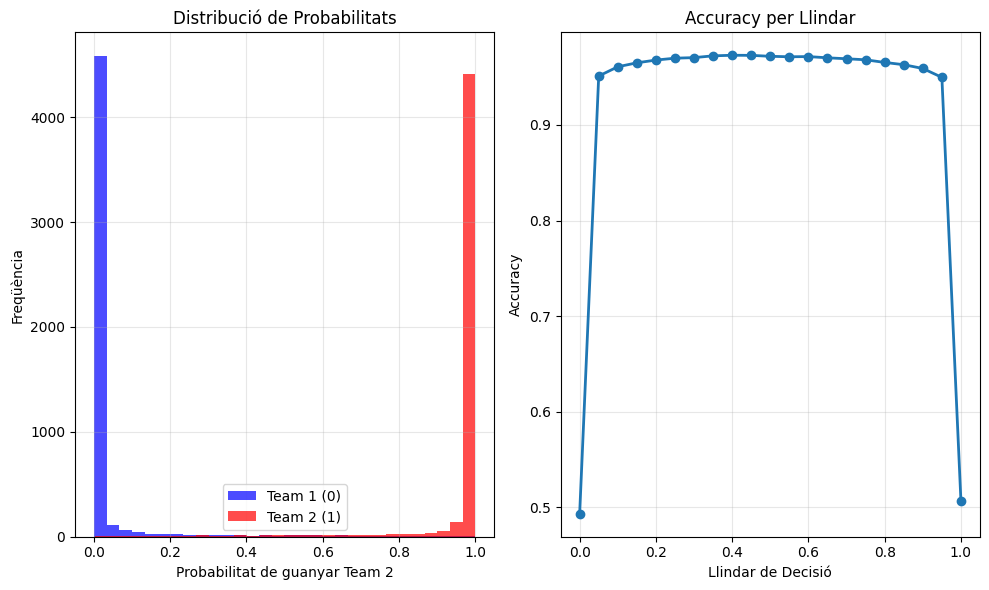

In [12]:
# Cèl·lula 9: Model 3 - Gradient Boosting
print(f"\n{'='*60}")
print("MODEL 3: GRADIENT BOOSTING")
print(f"{'='*60}")

from sklearn.ensemble import GradientBoostingClassifier

# Validació creuada
gb_base = GradientBoostingClassifier(random_state=42)
cv_scores_gb = cross_validation_analysis(gb_base, X_train, y_train, cv=5)

# Ajust d'hiperparàmetres
gb_best, gb_params, gb_search = hyperparameter_tuning(
    gb_base, 
    param_grids['gradient_boosting'], 
    X_train, 
    y_train, 
    cv=5, 
    method='random'
)

# Avaluació
gb_metrics, gb_cm = evaluate_model(gb_best, X_val, y_val, "Gradient Boosting (Val)")

# Guardar resultats
results['Gradient Boosting'] = {
    'model': gb_best,
    'params': gb_params,
    'cv_score': cv_scores_gb.mean(),
    'val_metrics': gb_metrics
}


MODEL 4: SVM

VALIDACIÓ CREUADA EXHAUSTIVA (CV=5)

📊 RESULTATS PER CADA MÈTRICA:

  ACCURACY     (Test):
    • Scores per fold: ['0.9714', '0.9686', '0.9666', '0.9733', '0.9740']
    • Mitjana: 0.9708 ± 0.0028
    • IC 95%: [0.9652, 0.9763]
    • Train vs Test gap: 0.0092 (OK)

  F1           (Test):
    • Scores per fold: ['0.9709', '0.9680', '0.9662', '0.9729', '0.9736']
    • Mitjana: 0.9703 ± 0.0028
    • IC 95%: [0.9648, 0.9759]
    • Train vs Test gap: 0.0093 (OK)

  PRECISION    (Test):
    • Scores per fold: ['0.9719', '0.9708', '0.9644', '0.9758', '0.9756']
    • Mitjana: 0.9717 ± 0.0041
    • IC 95%: [0.9636, 0.9798]
    • Train vs Test gap: 0.0085 (OK)

  RECALL       (Test):
    • Scores per fold: ['0.9700', '0.9653', '0.9680', '0.9700', '0.9716']
    • Mitjana: 0.9690 ± 0.0022
    • IC 95%: [0.9647, 0.9732]
    • Train vs Test gap: 0.0101 (OK)

  ROC_AUC      (Test):
    • Scores per fold: ['0.9965', '0.9959', '0.9962', '0.9971', '0.9974']
    • Mitjana: 0.9966 ± 0.0006
 

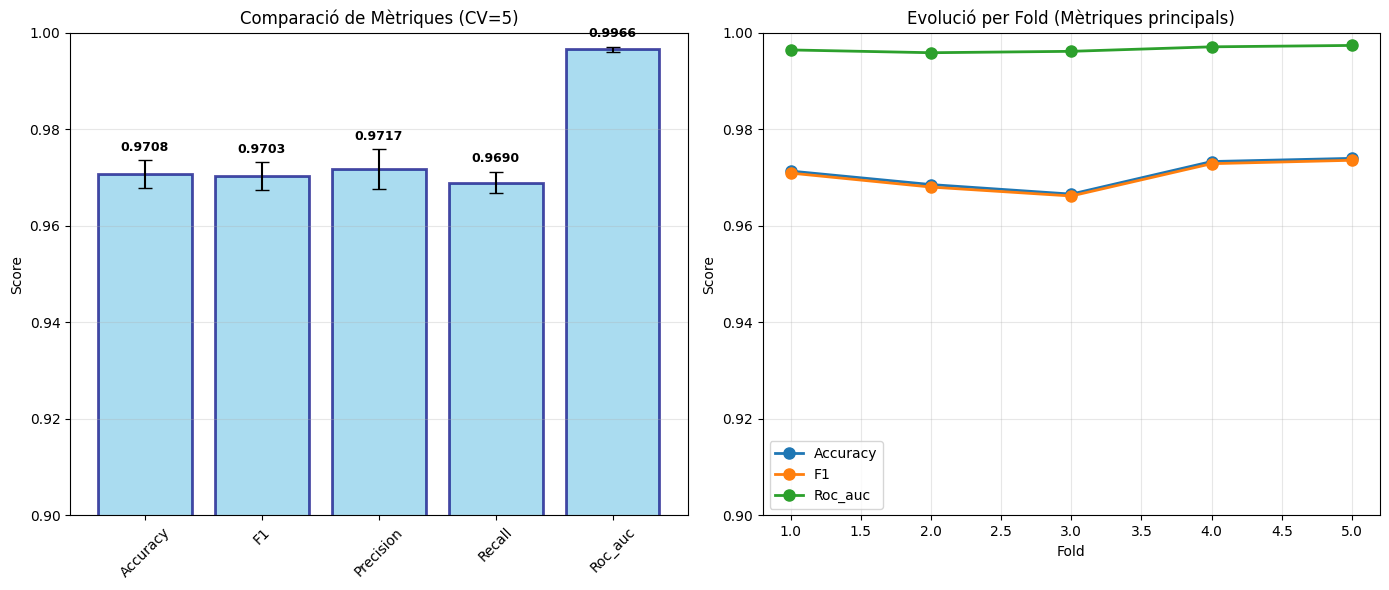

C:\Users\laiao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 12 candidates, totalling 36 fits
Millors paràmetres: {'kernel': 'rbf', 'gamma': 'auto', 'C': 1}
Millor score (CV) [accuracy]: 0.9700

AVALUACIÓ DEL MODEL: SVM (Val)
Valors únics a y_test: [0 1]


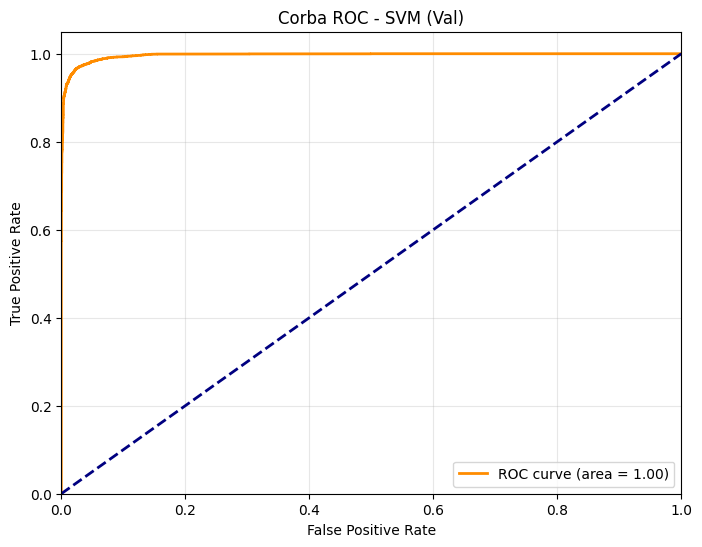


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9708
Precision: 0.9728
Recall: 0.9678
F1-Score: 0.9703
ROC-AUC: 0.9965

📊 Matriu de Confusió:
[[4995  135]
 [ 161 4834]]


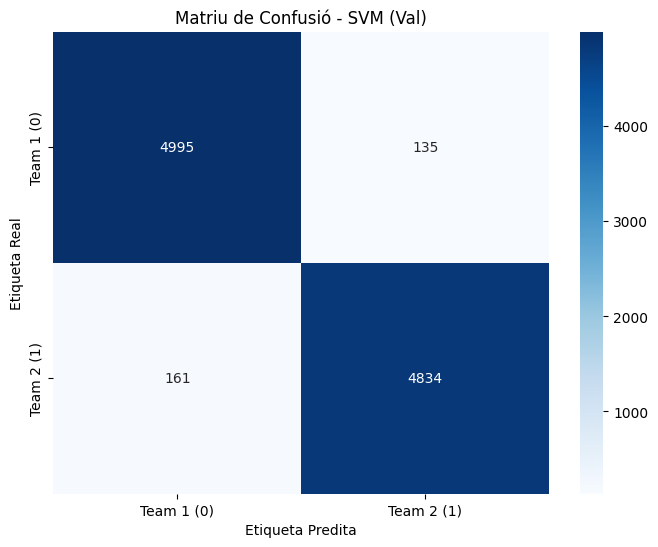


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.97      0.97      0.97      5130
  Team 2 (1)       0.97      0.97      0.97      4995

    accuracy                           0.97     10125
   macro avg       0.97      0.97      0.97     10125
weighted avg       0.97      0.97      0.97     10125



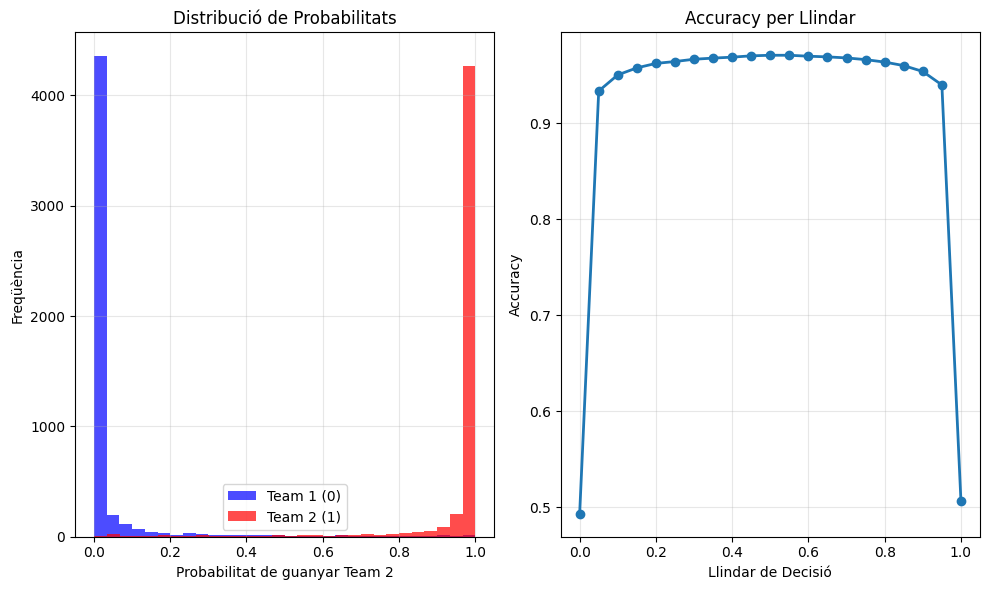

In [13]:
# Cèl·lula 10: Model 4 - SVM (necessita scaling)
print(f"\n{'='*60}")
print("MODEL 4: SVM")
print(f"{'='*60}")

from sklearn.svm import SVC

# Validació creuada
svm_base = SVC(probability=True, random_state=42)
cv_scores_svm = cross_validation_analysis(svm_base, X_train_scaled, y_train, cv=5)

# Ajust d'hiperparàmetres (versió simplificada i més ràpida)
svm_param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

svm_best, svm_params, svm_search = hyperparameter_tuning(
    svm_base, 
    svm_param_grid, 
    X_train_scaled, 
    y_train, 
    cv=3,  # Reducit a 3 folds per velocitat
    method='random'
)

# Avaluació
svm_metrics, svm_cm = evaluate_model(svm_best, X_val_scaled, y_val, "SVM (Val)")

# Guardar resultats
results['SVM'] = {
    'model': svm_best,
    'params': svm_params,
    'cv_score': cv_scores_svm.mean(),
    'val_metrics': svm_metrics
}


COMPARACIÓ DE TOTS ELS MODELS

📊 TAULA DE COMPARACIÓ:
                 Model  CV Score  Val Accuracy  Val Precision  Val Recall  \
1        Random Forest  0.973728      0.972741       0.972940    0.971772   
2    Gradient Boosting  0.973169      0.971852       0.972512    0.970370   
3                  SVM  0.970765      0.970765       0.972832    0.967768   
0  Logistic Regression  0.965695      0.965136       0.964758    0.964565   

   Val F1-Score  
1      0.972356  
2      0.971440  
3      0.970293  
0      0.964661  


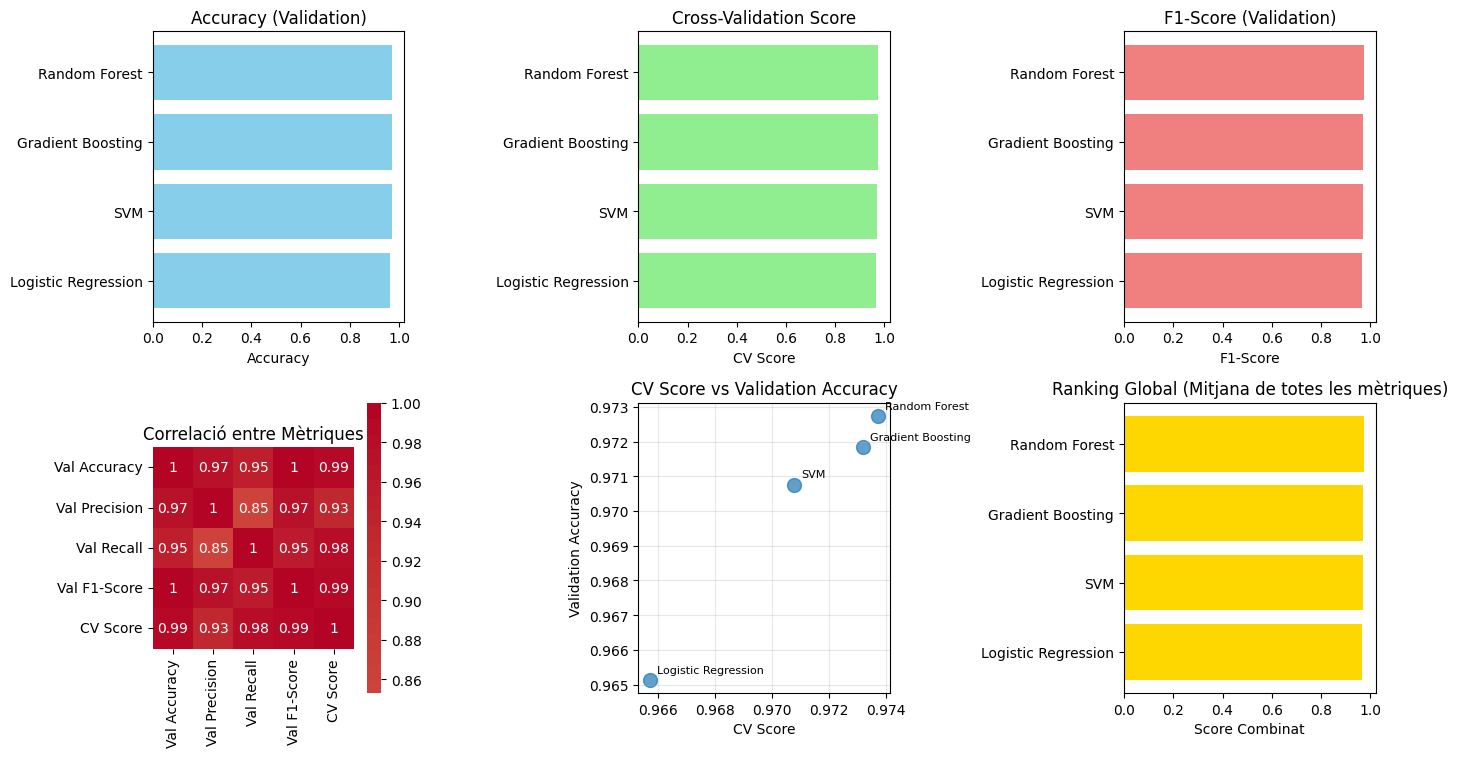

In [14]:
# Cèl·lula 11: COMPARACIÓ DE TOTS ELS MODELS
print(f"\n{'='*60}")
print("COMPARACIÓ DE TOTS ELS MODELS")
print(f"{'='*60}")

# Crear dataframe comparatiu
comparison_data = []
for model_name, model_info in results.items():
    comparison_data.append({
        'Model': model_name,
        'CV Score': model_info['cv_score'],
        'Val Accuracy': model_info['val_metrics']['Accuracy'],
        'Val Precision': model_info['val_metrics']['Precision'],
        'Val Recall': model_info['val_metrics']['Recall'],
        'Val F1-Score': model_info['val_metrics']['F1-Score']
    })

comparison_df = pd.DataFrame(comparison_data)
print("\n📊 TAULA DE COMPARACIÓ:")
print(comparison_df.sort_values('Val Accuracy', ascending=False))

# Gràfic de comparació
plt.figure(figsize=(14, 8))

# Accuracy comparatiu
plt.subplot(2, 3, 1)
sorted_df = comparison_df.sort_values('Val Accuracy', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Val Accuracy'], color='skyblue')
plt.title('Accuracy (Validation)')
plt.xlabel('Accuracy')

# CV Score comparatiu
plt.subplot(2, 3, 2)
sorted_df = comparison_df.sort_values('CV Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['CV Score'], color='lightgreen')
plt.title('Cross-Validation Score')
plt.xlabel('CV Score')

# F1-Score comparatiu
plt.subplot(2, 3, 3)
sorted_df = comparison_df.sort_values('Val F1-Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Val F1-Score'], color='lightcoral')
plt.title('F1-Score (Validation)')
plt.xlabel('F1-Score')

# Matriu de correlació de mètriques
plt.subplot(2, 3, 4)
metrics_corr = comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score', 'CV Score']].corr()
sns.heatmap(metrics_corr, annot=True, cmap='coolwarm', center=0, square=True)
plt.title('Correlació entre Mètriques')

# Scatter plot: CV Score vs Val Accuracy
plt.subplot(2, 3, 5)
plt.scatter(comparison_df['CV Score'], comparison_df['Val Accuracy'], s=100, alpha=0.7)
for i, row in comparison_df.iterrows():
    plt.annotate(row['Model'], (row['CV Score'], row['Val Accuracy']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)
plt.xlabel('CV Score')
plt.ylabel('Validation Accuracy')
plt.title('CV Score vs Validation Accuracy')
plt.grid(True, alpha=0.3)

# Ranking global
plt.subplot(2, 3, 6)
# Crear score combinat (mitjana de totes les mètriques)
comparison_df['Combined Score'] = comparison_df[['Val Accuracy', 'Val Precision', 'Val Recall', 'Val F1-Score', 'CV Score']].mean(axis=1)
sorted_df = comparison_df.sort_values('Combined Score', ascending=True)
plt.barh(sorted_df['Model'], sorted_df['Combined Score'], color='gold')
plt.title('Ranking Global (Mitjana de totes les mètriques)')
plt.xlabel('Score Combinat')

plt.tight_layout()
plt.show()


SELECCIÓ DEL MILLOR MODEL
🎯 MILLOR MODEL SELECCIONAT: Random Forest
📊 Paràmetres: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30}
🏆 Validation Accuracy: 0.9727

AVALUACIÓ FINAL AMB TEST SET

AVALUACIÓ DEL MODEL: Random Forest (Test Final)
Valors únics a y_test: [0 1]


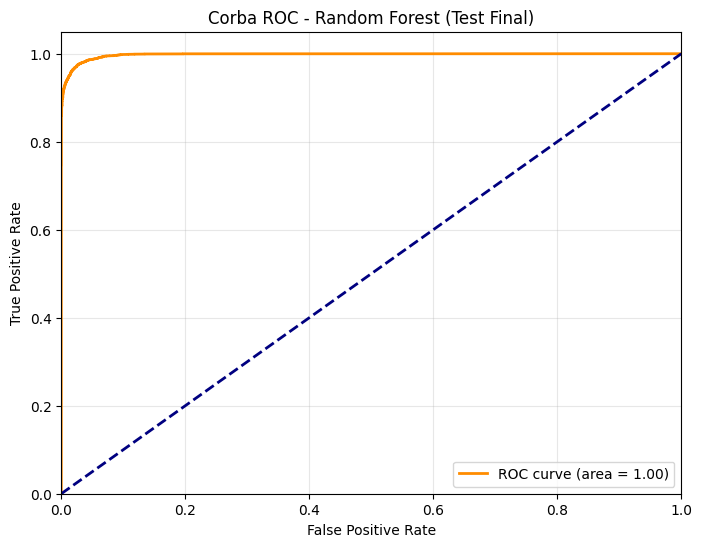


📊 MÈTRIQUES D'AVALUACIÓ:
Accuracy: 0.9742
Precision: 0.9721
Recall: 0.9758
F1-Score: 0.9739
ROC-AUC: 0.9976

📊 Matriu de Confusió:
[[4990  140]
 [ 121 4875]]


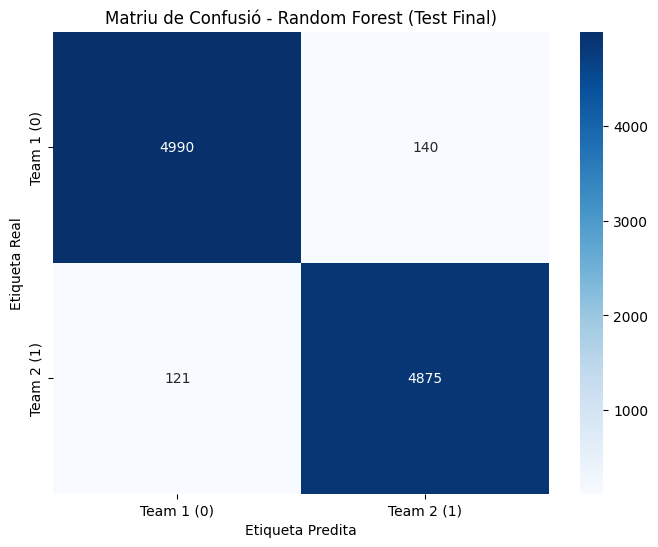


📋 Informe de Classificació:
              precision    recall  f1-score   support

  Team 1 (0)       0.98      0.97      0.97      5130
  Team 2 (1)       0.97      0.98      0.97      4996

    accuracy                           0.97     10126
   macro avg       0.97      0.97      0.97     10126
weighted avg       0.97      0.97      0.97     10126



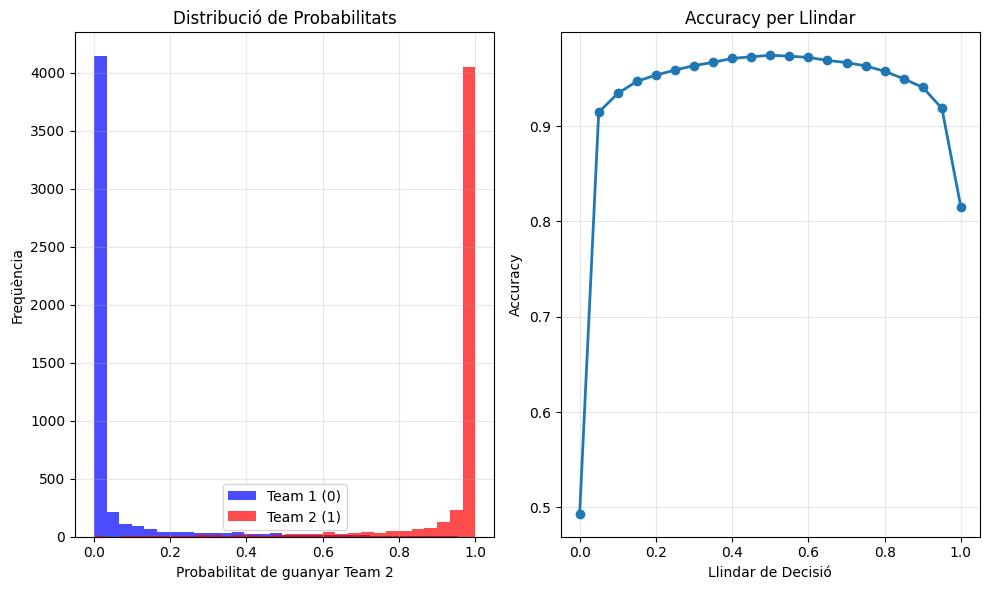

In [15]:
# Cèl·lula 12: SELECCIÓ DEL MILLOR MODEL I AVALUACIÓ FINAL
print(f"\n{'='*60}")
print("SELECCIÓ DEL MILLOR MODEL")
print(f"{'='*60}")

# Seleccionar el millor model basat en accuracy de validació
best_model_name = comparison_df.loc[comparison_df['Val Accuracy'].idxmax(), 'Model']
best_model_info = results[best_model_name]
best_model = best_model_info['model']

print(f"🎯 MILLOR MODEL SELECCIONAT: {best_model_name}")
print(f"📊 Paràmetres: {best_model_info['params']}")
print(f"🏆 Validation Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")

# Determinar si cal escalar les dades per al millor model
needs_scaling = best_model_name in ['Logistic Regression', 'SVM']
X_test_to_use = X_test_scaled if needs_scaling else X_test

# AVALUACIÓ FINAL AMB TEST SET
print(f"\n{'='*60}")
print("AVALUACIÓ FINAL AMB TEST SET")
print(f"{'='*60}")

# Avaluar el millor model amb el test set
test_metrics, test_cm = evaluate_model(best_model, X_test_to_use, y_test, 
                                       f"{best_model_name} (Test Final)")

In [16]:
# Cèl·lula 13: RESUM FINAL I CONCLUSIONS
print(f"\n{'='*60}")
print("RESUM FINAL I CONCLUSIONS")
print(f"{'='*60}")

print(f"\n📈 PERFORMANCE FINAL DEL MILLOR MODEL ({best_model_name}):")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"   • Test Precision: {test_metrics['Precision']:.4f}")
print(f"   • Test Recall: {test_metrics['Recall']:.4f}")
print(f"   • Test F1-Score: {test_metrics['F1-Score']:.4f}")
if 'ROC-AUC' in test_metrics:
    print(f"   • Test ROC-AUC: {test_metrics['ROC-AUC']:.4f}")

print(f"\n⚙️  HIPERPARÀMETRES OPTIMITZATS:")
for param, value in best_model_info['params'].items():
    print(f"   • {param}: {value}")

print(f"\n📊 COMPARACIÓ VALIDACIÓ vs TEST:")
print(f"   • Validation Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
print(f"   • Diferència: {abs(best_model_info['val_metrics']['Accuracy'] - test_metrics['Accuracy']):.4f}")



RESUM FINAL I CONCLUSIONS

📈 PERFORMANCE FINAL DEL MILLOR MODEL (Random Forest):
   • Test Accuracy: 0.9742
   • Test Precision: 0.9721
   • Test Recall: 0.9758
   • Test F1-Score: 0.9739
   • Test ROC-AUC: 0.9976

⚙️  HIPERPARÀMETRES OPTIMITZATS:
   • n_estimators: 100
   • min_samples_split: 5
   • min_samples_leaf: 1
   • max_features: sqrt
   • max_depth: 30

📊 COMPARACIÓ VALIDACIÓ vs TEST:
   • Validation Accuracy: 0.9727
   • Test Accuracy: 0.9742
   • Diferència: 0.0015



DIAGNÒSTIC: VERIFICANT PROBLEMES COMUNS

🔍 1. BUSCANT DATA LEAKAGE...

a) Top 10 correlacions amb 'winner':
winner               1.000000
t2_towerKills        0.785879
t1_towerKills        0.771400
t2_inhibitorKills    0.661194
t1_inhibitorKills    0.649453
firstInhibitor       0.536643
t2_dragonKills       0.497369
t1_dragonKills       0.472569
t2_baronKills        0.398886
firstTower           0.376366
Name: winner, dtype: float64

b) Columnes que podrien contenir informació del resultat:
   - firstTower
   - firstInhibitor
   - firstBaron
   - firstDragon
   - firstRiftHerald
   - t1_towerKills
   - t1_inhibitorKills
   - t1_baronKills
   - t1_dragonKills
   - t1_riftHeraldKills
   - t2_towerKills
   - t2_inhibitorKills
   - t2_baronKills
   - t2_dragonKills
   - t2_riftHeraldKills

🔍 2. MODEL DE LÍNIA BASE (BASELINE):
   Accuracy del DummyClassifier: 0.5067
   Si el teu model (Random Forest) dona 0.9727,
   està millorant en 0.4661

🔍 3. ANÀLISI DE LES DADES:
   Nombre total de mo

C:\Users\laiao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


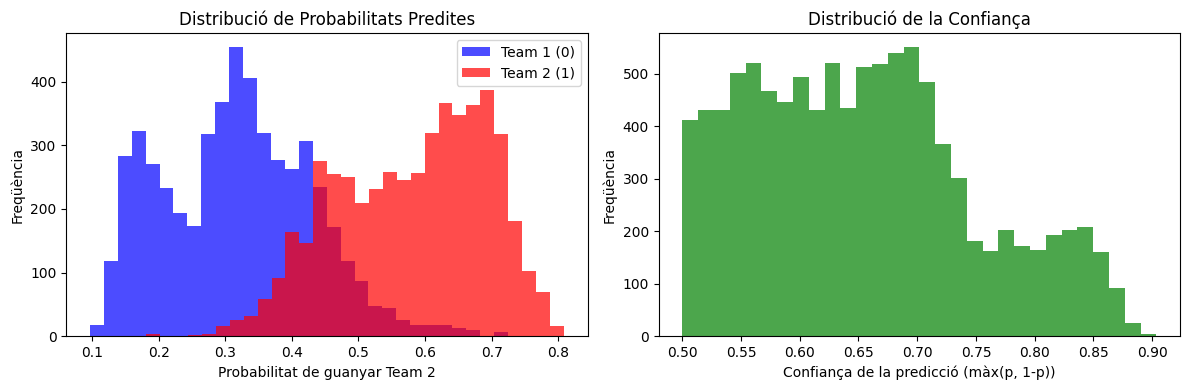

   Mitjana de confiança: 0.6531
   % prediccions amb confiança > 0.9: 0.0%

🔍 5. PROVA AMB MENYS DADES:


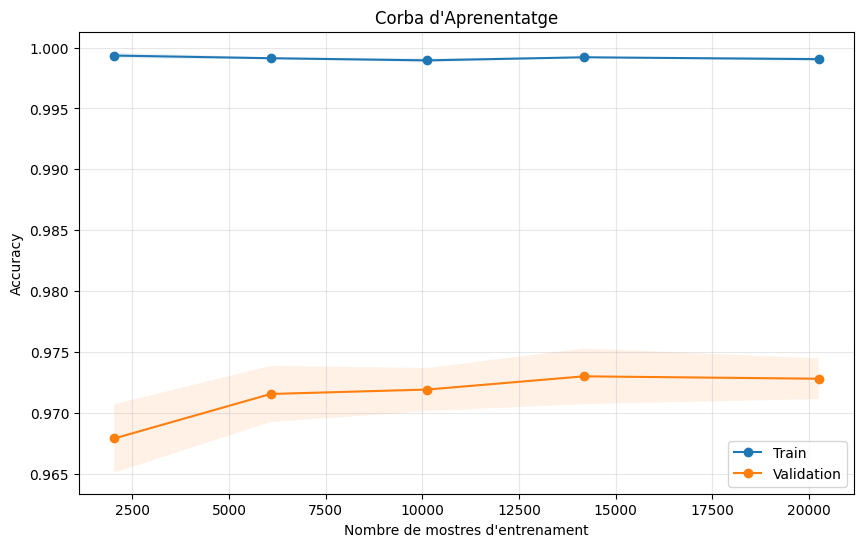


🔍 6. VERIFICANT SI EL PROBLEMA ÉS TRIVIAL...


In [17]:
# DIAGNÒSTIC DEL PROBLEMA
print(f"\n{'='*60}")
print("DIAGNÒSTIC: VERIFICANT PROBLEMES COMUNS")
print(f"{'='*60}")

# 1. Verificar si hi ha data leakage
print("\n🔍 1. BUSCANT DATA LEAKAGE...")

# a) Comprovar correlacions amb winner
print("\na) Top 10 correlacions amb 'winner':")
# Primer, crea una còpia temporal amb winner per calcular correlacions
temp_df = DataSet_cleaned.copy()
corr_with_target = temp_df.corr()['winner'].abs().sort_values(ascending=False)
print(corr_with_target.head(10))

# b) Buscar columnes que podrien contenir el resultat
print("\nb) Columnes que podrien contenir informació del resultat:")
keywords = ['win', 'kill', 'death', 'gold', 'tower', 'inhib', 'dragon', 'baron', 'herald']
for col in X.columns:
    col_lower = col.lower()
    for keyword in keywords:
        if keyword in col_lower:
            print(f"   - {col}")
            break

# 2. Model de línia base (baseline)
print("\n🔍 2. MODEL DE LÍNIA BASE (BASELINE):")
from sklearn.dummy import DummyClassifier

# Estratègia: predir la classe més freqüent
dummy = DummyClassifier(strategy='most_frequent', random_state=42)
dummy.fit(X_train_scaled, y_train)
y_dummy_pred = dummy.predict(X_val_scaled)
dummy_acc = accuracy_score(y_val, y_dummy_pred)

print(f"   Accuracy del DummyClassifier: {dummy_acc:.4f}")
print(f"   Si el teu model ({best_model_name}) dona {best_model_info['val_metrics']['Accuracy']:.4f},")
print(f"   està millorant en {best_model_info['val_metrics']['Accuracy'] - dummy_acc:.4f}")

# 3. Anàlisi de les dades
print("\n🔍 3. ANÀLISI DE LES DADES:")
print(f"   Nombre total de mostres: {len(X)}")
print(f"   Nombre de característiques: {len(X.columns)}")

# 4. Distribució de probabilitats (si el model les dóna)
if hasattr(best_model, 'predict_proba'):
    print("\n🔍 4. DISTRIBUCIÓ DE PROBABILITATS:")
    y_proba = best_model.predict_proba(X_val_scaled)[:, 1]
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.hist(y_proba[y_val == 0], bins=30, alpha=0.7, label='Team 1 (0)', color='blue')
    plt.hist(y_proba[y_val == 1], bins=30, alpha=0.7, label='Team 2 (1)', color='red')
    plt.xlabel('Probabilitat de guanyar Team 2')
    plt.ylabel('Freqüència')
    plt.title('Distribució de Probabilitats Predites')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    # Crear histograma de confiança
    confidence = np.where(y_proba > 0.5, y_proba, 1 - y_proba)
    plt.hist(confidence, bins=30, alpha=0.7, color='green')
    plt.xlabel('Confiança de la predicció (màx(p, 1-p))')
    plt.ylabel('Freqüència')
    plt.title('Distribució de la Confiança')
    
    plt.tight_layout()
    plt.show()
    
    print(f"   Mitjana de confiança: {confidence.mean():.4f}")
    print(f"   % prediccions amb confiança > 0.9: {(confidence > 0.9).mean()*100:.1f}%")

# 5. Prova amb un subconjunt de dades (learning curve simple)
print("\n🔍 5. PROVA AMB MENYS DADES:")
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_model, X_train_scaled, y_train,
    cv=3, scoring='accuracy', n_jobs=-1,
    train_sizes=[0.1, 0.3, 0.5, 0.7, 1.0]
)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores.mean(axis=1), 'o-', label='Train')
plt.plot(train_sizes, val_scores.mean(axis=1), 'o-', label='Validation')
plt.fill_between(train_sizes, 
                 train_scores.mean(axis=1) - train_scores.std(axis=1),
                 train_scores.mean(axis=1) + train_scores.std(axis=1),
                 alpha=0.1)
plt.fill_between(train_sizes,
                 val_scores.mean(axis=1) - val_scores.std(axis=1),
                 val_scores.mean(axis=1) + val_scores.std(axis=1),
                 alpha=0.1)
plt.xlabel('Nombre de mostres d\'entrenament')
plt.ylabel('Accuracy')
plt.title('Corba d\'Aprenentatge')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 6. Verificar si el problema és trivial
print("\n🔍 6. VERIFICANT SI EL PROBLEMA ÉS TRIVIAL...")

# Comptar quantes files tenen el mateix patró per ambdós equips
# (això podria indicar que alguna variable ho determina directament)

# Exemple: si hi ha una columna que és 1 per guanyador, 0 per perdedor
for col in X.columns:
    unique_vals = X[col].unique()
    if len(unique_vals) == 2 and set(unique_vals) == {0, 1}:
        # Verificar correlació perfecta
        correlation = np.corrcoef(X[col], y)[0, 1]
        if abs(correlation) > 0.95:
            print(f"   ALERTA: La columna '{col}' té correlació {correlation:.4f} amb 'winner'!")
            print(f"   Valors: {X[col].unique()}")
            print(f"   Potser és el resultat mateix disfressat!")

In [18]:

# DIAGNÒSTIC EXHAUSTIU - DETECCIÓ DE DATA LEAKAGE
print(f"\n{'='*80}")
print("🔍 DIAGNÒSTIC EXHAUSTIU: DETECCIÓ DE DATA LEAKAGE")
print(f"{'='*80}")

# 1. CORRELACIONS SOSPITOSES
print("\n1️⃣  TOP 30 CORRELACIONS AMB 'WINNER':")
print("="*60)
temp_df = DataSet_cleaned.copy()
corr_with_target = temp_df.corr()['winner'].abs().sort_values(ascending=False)
print(corr_with_target.head(30))

# 2. ANÁLISIS DE COLUMNAS PROBLEMÁTICAS
print("\n2️⃣  COLUMNES AMB CORRELACIÓ > 0.5:")
print("="*60)
high_corr = corr_with_target[corr_with_target > 0.5]
print(f"Total: {len(high_corr)} columnes")
for col, corr_val in high_corr.items():
    if col != 'winner':
        print(f"   • {col}: {corr_val:.4f}")

# 3. BASELINE COMPARISON
print("\n3️⃣  BASELINE (DUMMY CLASSIFIER):")
print("="*60)
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score

dummy_most_freq = DummyClassifier(strategy='most_frequent', random_state=42)
dummy_most_freq.fit(X_train_scaled, y_train)
baseline_acc = dummy_most_freq.score(X_val_scaled, y_val)

print(f"   Dummy (most_frequent) Accuracy: {baseline_acc:.4f}")
print(f"   {best_model_name} Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   Mejora: {best_model_info['val_metrics']['Accuracy'] - baseline_acc:.4f}")

if best_model_info['val_metrics']['Accuracy'] - baseline_acc < 0.05:
    print("   ⚠️  ALERTA: Mejora muy pequeña respecto a baseline!")

# 4. ANÁLISIS DE DISTRIBUCION DE DATOS
print("\n4️⃣  ANÁLISIS DE DISTRIBUCIÓN DE DATOS:")
print("="*60)
print(f"   • Total muestras: {len(X)}")
print(f"   • Total features: {len(X.columns)}")
print(f"   • Distribución target: {dict(y.value_counts())}")
print(f"   • % Train: {len(X_train)/len(X)*100:.1f}%")
print(f"   • % Val: {len(X_val)/len(X)*100:.1f}%")
print(f"   • % Test: {len(X_test)/len(X)*100:.1f}%")

# 5. PROBABILIDADES PREDICHAS
print("\n5️⃣  DISTRIBUCIÓN DE PROBABILIDADES:")
print("="*60)
if hasattr(best_model, 'predict_proba'):
    y_proba_val = best_model.predict_proba(X_val_scaled)[:, 1]
    confidence = np.where(y_proba_val > 0.5, y_proba_val, 1 - y_proba_val)
    
    print(f"   • Confianza media: {confidence.mean():.4f}")
    print(f"   • Confianza mín/máx: {confidence.min():.4f} / {confidence.max():.4f}")
    print(f"   • % predicciones > 0.9 confianza: {(confidence > 0.9).mean()*100:.1f}%")
    print(f"   • % predicciones > 0.95 confianza: {(confidence > 0.95).mean()*100:.1f}%")
    print(f"   • % predicciones > 0.99 confianza: {(confidence > 0.99).mean()*100:.1f}%")
    
    if (confidence > 0.95).mean() > 0.7:
        print("   ⚠️  ALERTA: ¡Demasiadas predicciones con confianza muy alta!")
        print("   Posible DATA LEAKAGE detectado.")

# 6. COMPARACIÓN VALIDACIÓN vs TEST
print("\n6️⃣  COMPARACIÓN VALIDACIÓN vs TEST:")
print("="*60)
print(f"   • Val Accuracy: {best_model_info['val_metrics']['Accuracy']:.4f}")
print(f"   • Test Accuracy: {test_metrics['Accuracy']:.4f}")
diff = abs(best_model_info['val_metrics']['Accuracy'] - test_metrics['Accuracy'])
print(f"   • Diferencia: {diff:.4f}")

if diff > 0.1:
    print("   ⚠️  ALERTA: ¡Gran diferencia entre validación y test!")
    print("   Posible OVERFITTING o DATA LEAKAGE.")

# 7. COLUMNAS SOSPECHOSAS
print("\n7️⃣  BÚSQUEDA DE COLUMNAS SOSPECHOSAS:")
print("="*60)
keywords = ['win', 'result', 'outcome', 'gold', 'kill', 'death', 'tower', 'inhib', 'dragon', 'baron']
suspicious = []
for col in X.columns:
    col_lower = col.lower()
    for keyword in keywords:
        if keyword in col_lower:
            suspicious.append(col)
            print(f"   ⚠️  {col}")
            break

if not suspicious:
    print("   ✅ No se encontraron columnas sospechosas obvias")

# 8. CORRELACIÓN PERFECTA
print("\n8️⃣  BÚSQUEDA DE CORRELACIONES PERFECTAS:")
print("="*60)
for col in X.columns:
    X_col = X[col].fillna(0)
    try:
        correlation = np.corrcoef(X_col, y)[0, 1]
        if abs(correlation) > 0.98:
            print(f"   ⚠️  {col}: correlación = {correlation:.4f}")
    except:
        pass

print("\n✅ DIAGNÓSTICO COMPLETADO")
print("="*80)


🔍 DIAGNÒSTIC EXHAUSTIU: DETECCIÓ DE DATA LEAKAGE

1️⃣  TOP 30 CORRELACIONS AMB 'WINNER':
winner                   1.000000
t2_towerKills            0.785879
t1_towerKills            0.771400
t2_inhibitorKills        0.661194
t1_inhibitorKills        0.649453
firstInhibitor           0.536643
t2_dragonKills           0.497369
t1_dragonKills           0.472569
t2_baronKills            0.398886
firstTower               0.376366
t1_baronKills            0.369577
sinergia_diferencia      0.354626
firstDragon              0.310315
firstBaron               0.261669
team1_sinergia_promig    0.259857
team2_sinergia_promig    0.259453
t2_riftHeraldKills       0.226406
t1_riftHeraldKills       0.218166
firstBlood               0.175286
firstRiftHerald          0.120044
gameId                   0.014920
t1_score_sum_sinergia    0.012420
t2_score_sum_sinergia    0.011883
tag_score_diff           0.005607
team1_tag_score          0.004856
team1_comb_index         0.003700
team2_comb_index         0

C:\Users\laiao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(
